## RUN ONCE ~ CREATE VIRTUAL ENV

In [ ]:
from google.colab import drive
from os.path import join
import sys

def mount_drive(ROOT):
    drive.mount(ROOT, force_remount=True)

ROOT = '/content/drive'
mount_drive(ROOT)

MY_GOOGLE_DRIVE_PATH = 'MyDrive/RL_NLP/PPO_NEW/NLP_RL_Docker_Version'
PROJECT_PATH = join(ROOT, MY_GOOGLE_DRIVE_PATH)
print("PROJECT_PATH: ", PROJECT_PATH)
%cd "{PROJECT_PATH}"
sys.path.insert(0, PROJECT_PATH)

In [ ]:
!pip3 install virtualenv
!virtualenv myenv
!source myenv/bin/activate

In [ ]:
!pip install -r "{PROJECT_PATH}/metadata/requirements.txt"
!pip install -r "{PROJECT_PATH}/metadata/requirements1.txt"

In [ ]:
!pip install -e .

In [ ]:
!deactivate

## RUN FROM HERE.

In [ ]:
from google.colab import drive
from os.path import join
import sys

def mount_drive(ROOT):
    drive.mount(ROOT, force_remount=True)

ROOT = '/content/drive'
mount_drive(ROOT)

MY_GOOGLE_DRIVE_PATH = 'MyDrive/RL_NLP/PPO_NEW/NLP_RL_Docker_Version'
PROJECT_PATH = join(ROOT, MY_GOOGLE_DRIVE_PATH)
print("PROJECT_PATH: ", PROJECT_PATH)
%cd "{PROJECT_PATH}"
sys.path.insert(0, PROJECT_PATH)

In [ ]:
# Doesn't work because collab uses different shell than virtualenv !source myenv/bin/activate
!pip install transformers
!mkdir results

## !!IMPORTANT
> Ignore all cell before this, 
> if you are running from DOCKER in your local machine, run
> the cell below. Don't run the cell below otherwise.


In [1]:
%cd /NLP_RL_Docker_Version
!pip install -e .

/NLP_RL_Docker_Version
Obtaining file:///NLP_RL_Docker_Version
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [14 lines of output]
      error: Multiple top-level packages discovered in a flat-layout: ['results', 'ENV_UTIL', 'metadata', 'transfer_task'].
      
      To avoid accidental inclusion of unwanted files or directories,
      setuptools will not proceed with this build.
      
      If you are trying to create a single distribution with multiple packages
      on purpose, you should not rely on automatic discovery.
      Instead, consider the following options:
      
      1. set up custom discovery (`find` directive with `include` or `exclude`)
      2. use a `src-layout`
      3. explicitly set `py_modules` or `packages` with a list of names
      
      To find more information, look for "package discovery" on setuptools docs.
      [end of output]
  
  note: 

In [2]:
!pip install transformers
!mkdir results

mkdir: cannot create directory ‘results’: File exists


In [3]:
import numpy as np
import pandas as pd
import time
import utils as U
import model as M
import model_nlp as MNLP
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import json
import copy
import gym
import sys
import os
sys.path.append(f'{os.getcwd()}/gym-examples')
import gym_examples
import numpy as np
import json


suffix = [['easy','medium','hard','naive'],['fnlp_easy','fnlp_medium','fnlp_hard','fnlp_naive']]

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
def plot_ppo(name):
    arr=[]
    with open(f'results/test_reward_list_{name}.json', 'r') as file:
        arr=json.load(file)
        x,y=[arr[i][0] for i in range(len(arr))], [arr[i][1] for i in range(len(arr))]
        plt.plot(x,y)
        plt.xlabel(f'Frame Number')
        plt.ylabel(f'Cumulative Reward')
        plt.show()

In [5]:
def run_best_env(number,name):
    str_arr = name.split('_')
    opt = 0
    if 'fnlp' in str_arr:
        opt = 1
    def policy(S):
        nonlocal opt
        if opt == 0:
            dist, value = model(S['visual'])
        elif opt == 1:
            dist, value = model(S['visual'],S['text'])
        action = dist.sample()
        return action.cpu().numpy().item()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if opt == 0:
        model = M.NNModel().to(device)
    elif opt == 1:
        model = MNLP.NNModelNLP().to(device)
    model.load_state_dict(torch.load(f'results/model_{name}.ml'))
    dbg=True
    episodes=1
    env = gym.make('gym_examples/RlNlpWorld-v0',render_mode="rgb_array")
    for _ in range(episodes):
        cumulative_reward,steps=0,0
        observation = env.reset(set_no=number,seed=42)
        state = copy.deepcopy(observation)
        observation['state'] = U.pre_process(observation)
        if opt == 1:
            observation['text'] = U.pre_process_text(model,observation)
        while True:
            print(observation['text'])
            if dbg==True:
                plt.imshow(state['visual'])
                plt.show()
            action = policy(observation)  # User-defined policy function
            observation, reward, terminated, info = env.step(action)
            print(f'Action {action}')
            state = copy.deepcopy(observation)
            observation['state'] = U.pre_process(observation)
            if opt == 1:
                observation['text'] = U.pre_process_text(model,observation)
            cumulative_reward += reward
            steps += 1
            if terminated: break
        print(f'Cumulative Reward ~ {cumulative_reward}; TimeTaken ~ {steps}')
    env.close()

### Best Agent

In [6]:
from transformers import BertTokenizer 
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def best_env(number=1):
    f,s,t = number//100,(number%100)//10,number%10
    exp_action = [0,3]*f + [1,4]*s + [2,5]*t
    exp_action_indx = 0
    def human_policy(observation):
        nonlocal exp_action_indx
        # action=int(input())
        try:
            action = exp_action[exp_action_indx]
            exp_action_indx += 1
        except Exception as e:
            action = -1
        return action
    dbg=True
    episodes=1
    action, reward = None, None
    env = gym.make('gym_examples/RlNlpWorld-v0',render_mode="rgb_array", instr_type="policy")
    for _ in range(episodes):
        cumulative_reward,steps=0,0
        observation = env.reset(set_no=number)
        cnt,mx_iter=0,1002
        while steps<mx_iter:
            token = tokenizer(observation['text'])['input_ids']
            print(f"ACTION[{action}] REWARD[{reward}]\n" +\
                  f"{observation['text']}\n {token}\n" +\
                  f"{tokenizer.convert_ids_to_tokens(token)}\n" +\
                  f"{len(tokenizer.convert_ids_to_tokens(token))}"
                  )
            if dbg==True:
                plt.imshow(observation['visual'])
                plt.show()
            action = human_policy(observation)  # User-defined policy function
            print(action)
            observation, reward, terminated, info = env.step(action)
            cumulative_reward+=reward
            steps+=1
            if terminated:
                break
        print(f'Cumulative Reward ~ {cumulative_reward}; TimeTaken ~ {steps}')
    env.close()

/usr/local/lib/python3.10/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:2871: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('mpl_toolkits')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibilit

ACTION[None] REWARD[None]
This is nine hundred eighty six. Let's use our blocks to build the number. To build nine hundred eighty six , pick up the first hundred block .
 [101, 2023, 2003, 3157, 3634, 12021, 2416, 1012, 2292, 1005, 1055, 2224, 2256, 5991, 2000, 3857, 1996, 2193, 1012, 2000, 3857, 3157, 3634, 12021, 2416, 1010, 4060, 2039, 1996, 2034, 3634, 3796, 1012, 102]
['[CLS]', 'this', 'is', 'nine', 'hundred', 'eighty', 'six', '.', 'let', "'", 's', 'use', 'our', 'blocks', 'to', 'build', 'the', 'number', '.', 'to', 'build', 'nine', 'hundred', 'eighty', 'six', ',', 'pick', 'up', 'the', 'first', 'hundred', 'block', '.', '[SEP]']
34


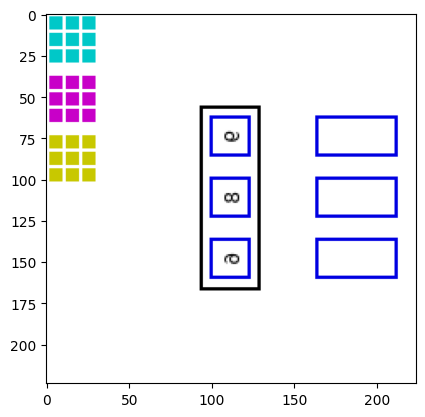

0
ACTION[0] REWARD[0.1]
Put the hundred block in the hundred's place .
 [101, 2404, 1996, 3634, 3796, 1999, 1996, 3634, 1005, 1055, 2173, 1012, 102]
['[CLS]', 'put', 'the', 'hundred', 'block', 'in', 'the', 'hundred', "'", 's', 'place', '.', '[SEP]']
13


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:165: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


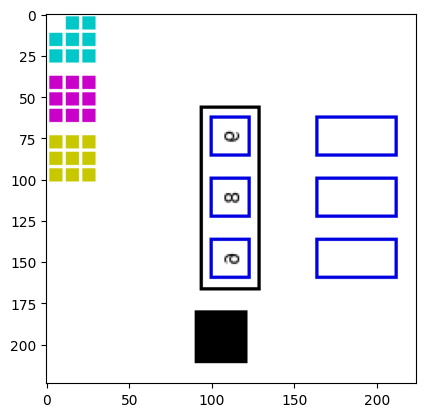

3
ACTION[3] REWARD[0.1]
Next , pick up the second hundred block .
 [101, 2279, 1010, 4060, 2039, 1996, 2117, 3634, 3796, 1012, 102]
['[CLS]', 'next', ',', 'pick', 'up', 'the', 'second', 'hundred', 'block', '.', '[SEP]']
11


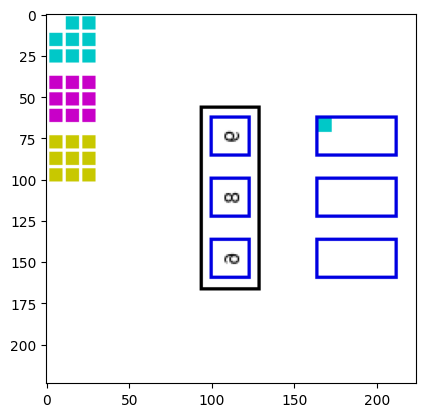

0
ACTION[0] REWARD[0.1]
Put the hundred block in the hundred's place .
 [101, 2404, 1996, 3634, 3796, 1999, 1996, 3634, 1005, 1055, 2173, 1012, 102]
['[CLS]', 'put', 'the', 'hundred', 'block', 'in', 'the', 'hundred', "'", 's', 'place', '.', '[SEP]']
13


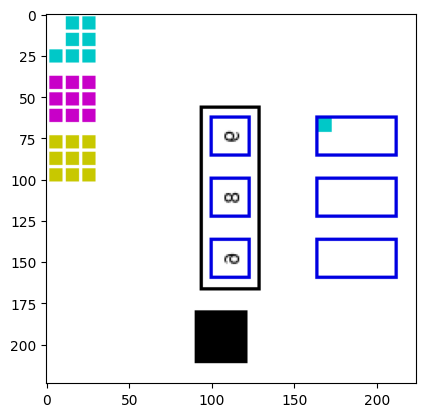

3
ACTION[3] REWARD[0.1]
Next , pick up the third hundred block .
 [101, 2279, 1010, 4060, 2039, 1996, 2353, 3634, 3796, 1012, 102]
['[CLS]', 'next', ',', 'pick', 'up', 'the', 'third', 'hundred', 'block', '.', '[SEP]']
11


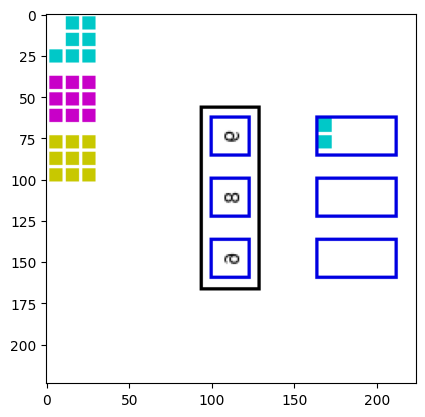

0
ACTION[0] REWARD[0.1]
Put the hundred block in the hundred's place .
 [101, 2404, 1996, 3634, 3796, 1999, 1996, 3634, 1005, 1055, 2173, 1012, 102]
['[CLS]', 'put', 'the', 'hundred', 'block', 'in', 'the', 'hundred', "'", 's', 'place', '.', '[SEP]']
13


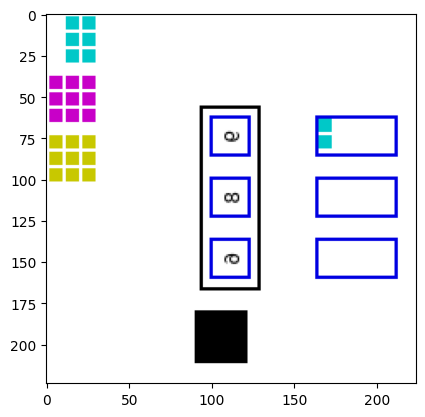

3
ACTION[3] REWARD[0.1]
Next , pick up the fourth hundred block .
 [101, 2279, 1010, 4060, 2039, 1996, 2959, 3634, 3796, 1012, 102]
['[CLS]', 'next', ',', 'pick', 'up', 'the', 'fourth', 'hundred', 'block', '.', '[SEP]']
11


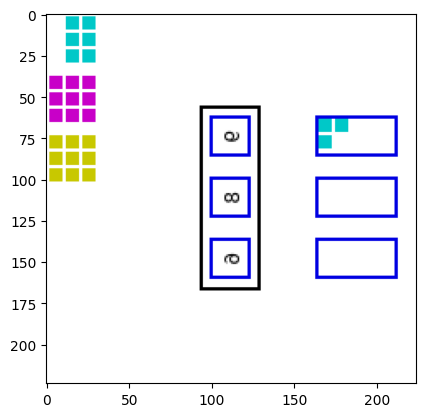

0
ACTION[0] REWARD[0.1]
Put the hundred block in the hundred's place .
 [101, 2404, 1996, 3634, 3796, 1999, 1996, 3634, 1005, 1055, 2173, 1012, 102]
['[CLS]', 'put', 'the', 'hundred', 'block', 'in', 'the', 'hundred', "'", 's', 'place', '.', '[SEP]']
13


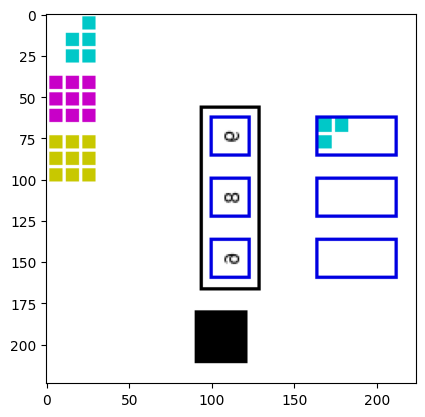

3
ACTION[3] REWARD[0.1]
Next , pick up the fifth hundred block .
 [101, 2279, 1010, 4060, 2039, 1996, 3587, 3634, 3796, 1012, 102]
['[CLS]', 'next', ',', 'pick', 'up', 'the', 'fifth', 'hundred', 'block', '.', '[SEP]']
11


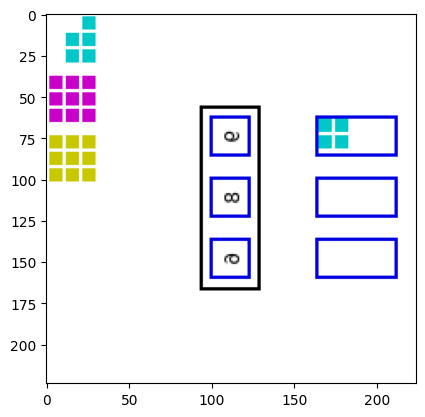

0
ACTION[0] REWARD[0.1]
Put the hundred block in the hundred's place .
 [101, 2404, 1996, 3634, 3796, 1999, 1996, 3634, 1005, 1055, 2173, 1012, 102]
['[CLS]', 'put', 'the', 'hundred', 'block', 'in', 'the', 'hundred', "'", 's', 'place', '.', '[SEP]']
13


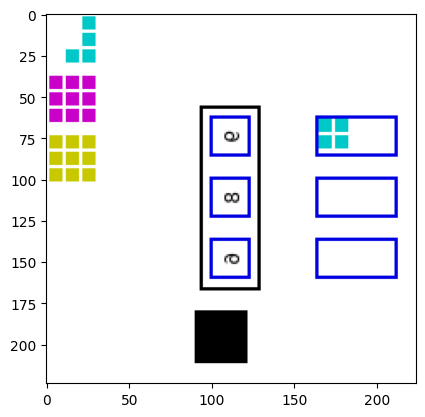

3
ACTION[3] REWARD[0.1]
Next , pick up the sixth hundred block .
 [101, 2279, 1010, 4060, 2039, 1996, 4369, 3634, 3796, 1012, 102]
['[CLS]', 'next', ',', 'pick', 'up', 'the', 'sixth', 'hundred', 'block', '.', '[SEP]']
11


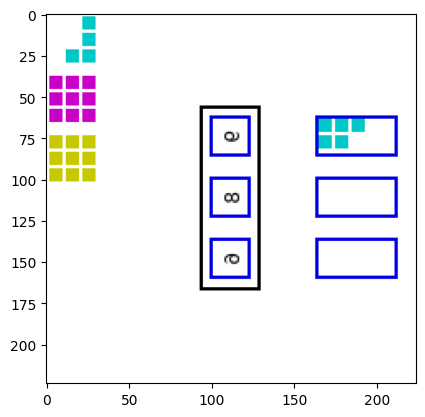

0
ACTION[0] REWARD[0.1]
Put the hundred block in the hundred's place .
 [101, 2404, 1996, 3634, 3796, 1999, 1996, 3634, 1005, 1055, 2173, 1012, 102]
['[CLS]', 'put', 'the', 'hundred', 'block', 'in', 'the', 'hundred', "'", 's', 'place', '.', '[SEP]']
13


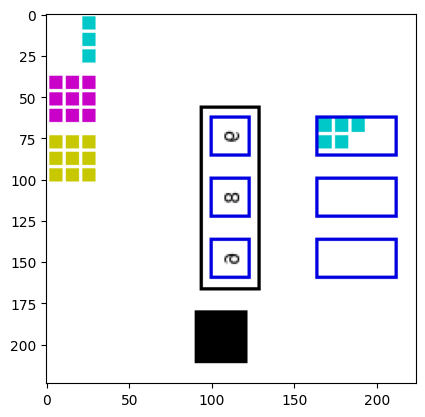

3
ACTION[3] REWARD[0.1]
Next , pick up the seventh hundred block .
 [101, 2279, 1010, 4060, 2039, 1996, 5066, 3634, 3796, 1012, 102]
['[CLS]', 'next', ',', 'pick', 'up', 'the', 'seventh', 'hundred', 'block', '.', '[SEP]']
11


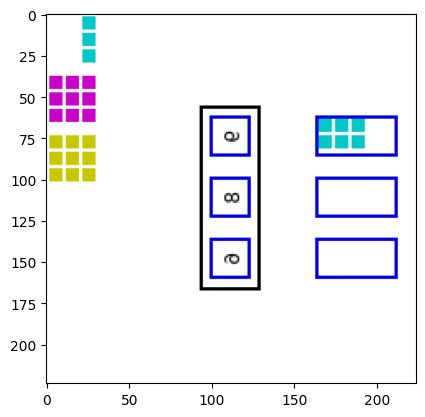

0
ACTION[0] REWARD[0.1]
Put the hundred block in the hundred's place .
 [101, 2404, 1996, 3634, 3796, 1999, 1996, 3634, 1005, 1055, 2173, 1012, 102]
['[CLS]', 'put', 'the', 'hundred', 'block', 'in', 'the', 'hundred', "'", 's', 'place', '.', '[SEP]']
13


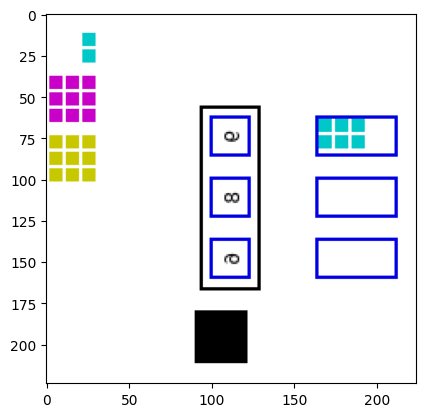

3
ACTION[3] REWARD[0.1]
Next , pick up the eighth hundred block .
 [101, 2279, 1010, 4060, 2039, 1996, 5964, 3634, 3796, 1012, 102]
['[CLS]', 'next', ',', 'pick', 'up', 'the', 'eighth', 'hundred', 'block', '.', '[SEP]']
11


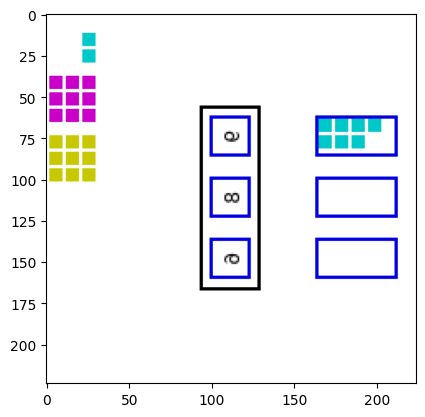

0
ACTION[0] REWARD[0.1]
Put the hundred block in the hundred's place .
 [101, 2404, 1996, 3634, 3796, 1999, 1996, 3634, 1005, 1055, 2173, 1012, 102]
['[CLS]', 'put', 'the', 'hundred', 'block', 'in', 'the', 'hundred', "'", 's', 'place', '.', '[SEP]']
13


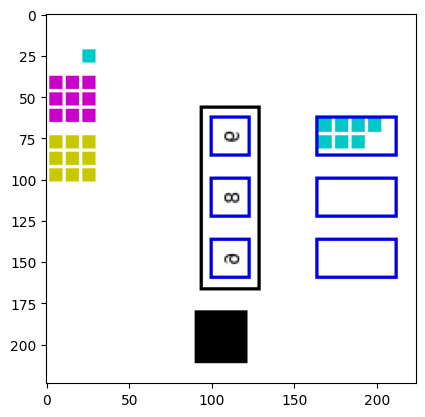

3
ACTION[3] REWARD[0.1]
Next , pick up the ninth hundred block .
 [101, 2279, 1010, 4060, 2039, 1996, 6619, 3634, 3796, 1012, 102]
['[CLS]', 'next', ',', 'pick', 'up', 'the', 'ninth', 'hundred', 'block', '.', '[SEP]']
11


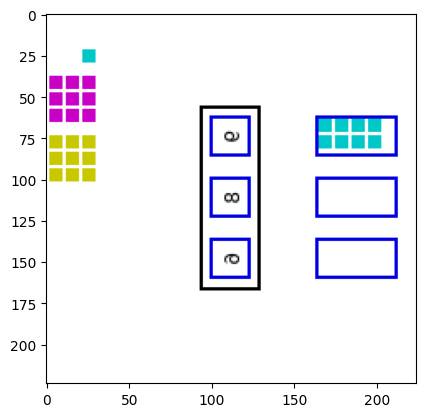

0
ACTION[0] REWARD[0.1]
Put the hundred block in the hundred's place .
 [101, 2404, 1996, 3634, 3796, 1999, 1996, 3634, 1005, 1055, 2173, 1012, 102]
['[CLS]', 'put', 'the', 'hundred', 'block', 'in', 'the', 'hundred', "'", 's', 'place', '.', '[SEP]']
13


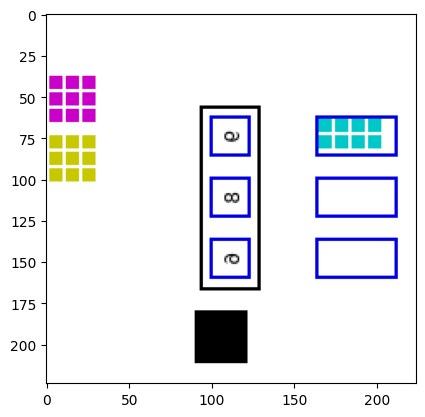

3
ACTION[3] REWARD[0.1]
Next , pick up the first ten block .
 [101, 2279, 1010, 4060, 2039, 1996, 2034, 2702, 3796, 1012, 102]
['[CLS]', 'next', ',', 'pick', 'up', 'the', 'first', 'ten', 'block', '.', '[SEP]']
11


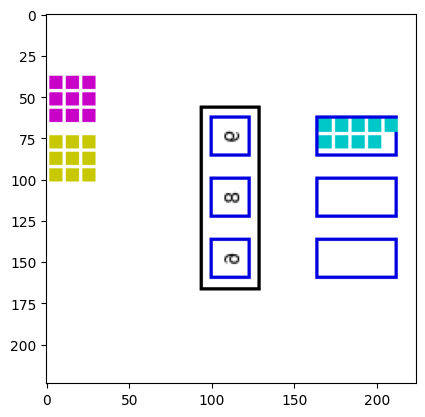

1
ACTION[1] REWARD[0.1]
Put the ten block in the ten's place .
 [101, 2404, 1996, 2702, 3796, 1999, 1996, 2702, 1005, 1055, 2173, 1012, 102]
['[CLS]', 'put', 'the', 'ten', 'block', 'in', 'the', 'ten', "'", 's', 'place', '.', '[SEP]']
13


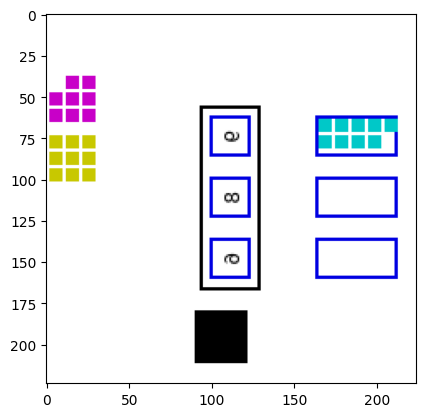

4
ACTION[4] REWARD[0.1]
Next , pick up the second ten block .
 [101, 2279, 1010, 4060, 2039, 1996, 2117, 2702, 3796, 1012, 102]
['[CLS]', 'next', ',', 'pick', 'up', 'the', 'second', 'ten', 'block', '.', '[SEP]']
11


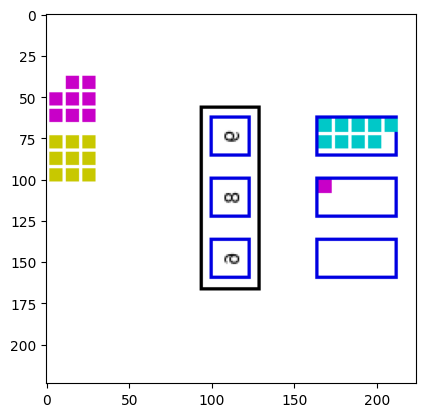

1
ACTION[1] REWARD[0.1]
Put the ten block in the ten's place .
 [101, 2404, 1996, 2702, 3796, 1999, 1996, 2702, 1005, 1055, 2173, 1012, 102]
['[CLS]', 'put', 'the', 'ten', 'block', 'in', 'the', 'ten', "'", 's', 'place', '.', '[SEP]']
13


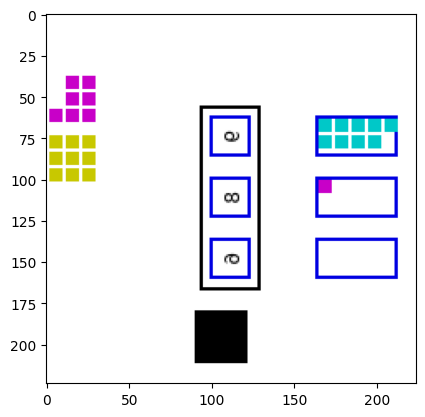

4
ACTION[4] REWARD[0.1]
Next , pick up the third ten block .
 [101, 2279, 1010, 4060, 2039, 1996, 2353, 2702, 3796, 1012, 102]
['[CLS]', 'next', ',', 'pick', 'up', 'the', 'third', 'ten', 'block', '.', '[SEP]']
11


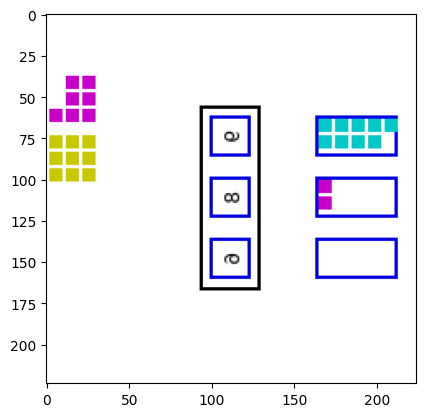

1
ACTION[1] REWARD[0.1]
Put the ten block in the ten's place .
 [101, 2404, 1996, 2702, 3796, 1999, 1996, 2702, 1005, 1055, 2173, 1012, 102]
['[CLS]', 'put', 'the', 'ten', 'block', 'in', 'the', 'ten', "'", 's', 'place', '.', '[SEP]']
13


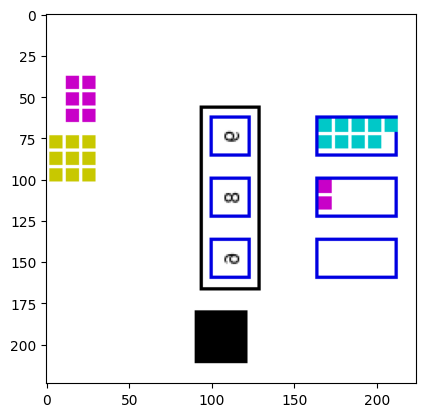

4
ACTION[4] REWARD[0.1]
Next , pick up the fourth ten block .
 [101, 2279, 1010, 4060, 2039, 1996, 2959, 2702, 3796, 1012, 102]
['[CLS]', 'next', ',', 'pick', 'up', 'the', 'fourth', 'ten', 'block', '.', '[SEP]']
11


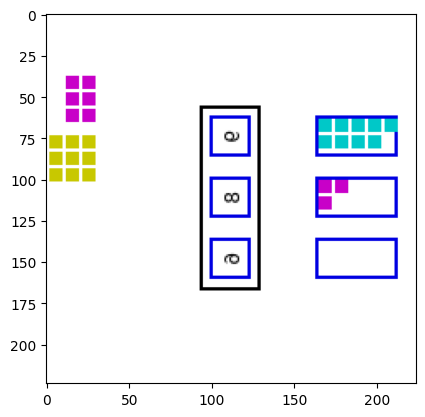

1
ACTION[1] REWARD[0.1]
Put the ten block in the ten's place .
 [101, 2404, 1996, 2702, 3796, 1999, 1996, 2702, 1005, 1055, 2173, 1012, 102]
['[CLS]', 'put', 'the', 'ten', 'block', 'in', 'the', 'ten', "'", 's', 'place', '.', '[SEP]']
13


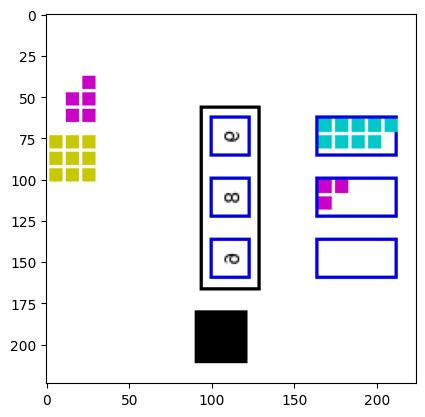

4
ACTION[4] REWARD[0.1]
Next , pick up the fifth ten block .
 [101, 2279, 1010, 4060, 2039, 1996, 3587, 2702, 3796, 1012, 102]
['[CLS]', 'next', ',', 'pick', 'up', 'the', 'fifth', 'ten', 'block', '.', '[SEP]']
11


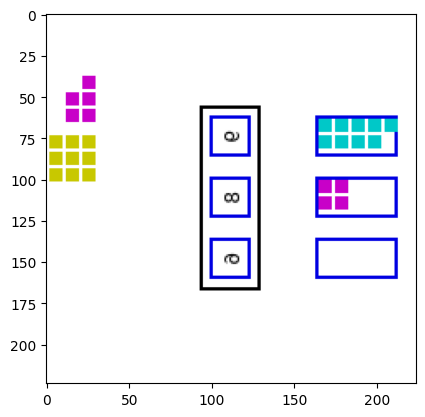

1
ACTION[1] REWARD[0.1]
Put the ten block in the ten's place .
 [101, 2404, 1996, 2702, 3796, 1999, 1996, 2702, 1005, 1055, 2173, 1012, 102]
['[CLS]', 'put', 'the', 'ten', 'block', 'in', 'the', 'ten', "'", 's', 'place', '.', '[SEP]']
13


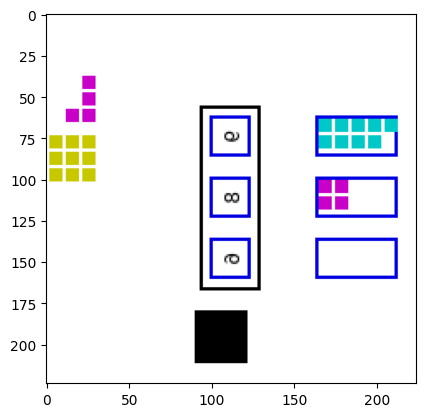

4
ACTION[4] REWARD[0.1]
Next , pick up the sixth ten block .
 [101, 2279, 1010, 4060, 2039, 1996, 4369, 2702, 3796, 1012, 102]
['[CLS]', 'next', ',', 'pick', 'up', 'the', 'sixth', 'ten', 'block', '.', '[SEP]']
11


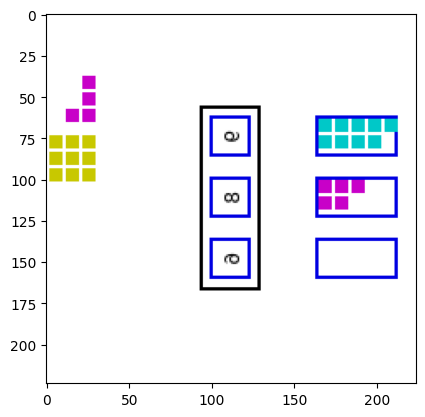

1
ACTION[1] REWARD[0.1]
Put the ten block in the ten's place .
 [101, 2404, 1996, 2702, 3796, 1999, 1996, 2702, 1005, 1055, 2173, 1012, 102]
['[CLS]', 'put', 'the', 'ten', 'block', 'in', 'the', 'ten', "'", 's', 'place', '.', '[SEP]']
13


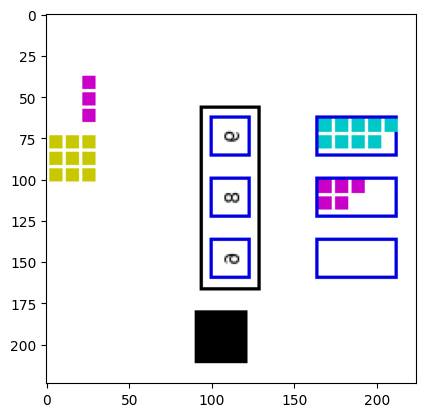

4
ACTION[4] REWARD[0.1]
Next , pick up the seventh ten block .
 [101, 2279, 1010, 4060, 2039, 1996, 5066, 2702, 3796, 1012, 102]
['[CLS]', 'next', ',', 'pick', 'up', 'the', 'seventh', 'ten', 'block', '.', '[SEP]']
11


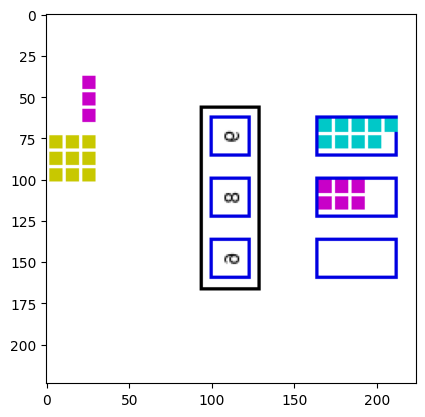

1
ACTION[1] REWARD[0.1]
Put the ten block in the ten's place .
 [101, 2404, 1996, 2702, 3796, 1999, 1996, 2702, 1005, 1055, 2173, 1012, 102]
['[CLS]', 'put', 'the', 'ten', 'block', 'in', 'the', 'ten', "'", 's', 'place', '.', '[SEP]']
13


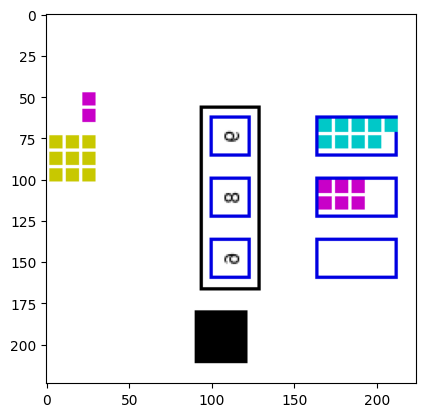

4
ACTION[4] REWARD[0.1]
Next , pick up the eighth ten block .
 [101, 2279, 1010, 4060, 2039, 1996, 5964, 2702, 3796, 1012, 102]
['[CLS]', 'next', ',', 'pick', 'up', 'the', 'eighth', 'ten', 'block', '.', '[SEP]']
11


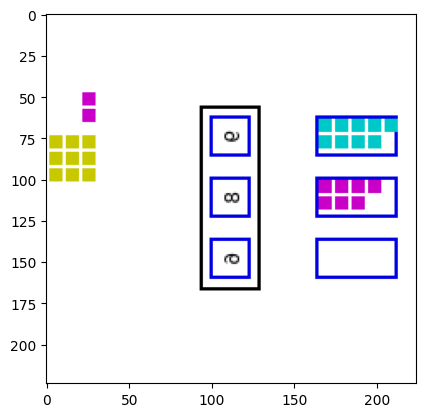

1
ACTION[1] REWARD[0.1]
Put the ten block in the ten's place .
 [101, 2404, 1996, 2702, 3796, 1999, 1996, 2702, 1005, 1055, 2173, 1012, 102]
['[CLS]', 'put', 'the', 'ten', 'block', 'in', 'the', 'ten', "'", 's', 'place', '.', '[SEP]']
13


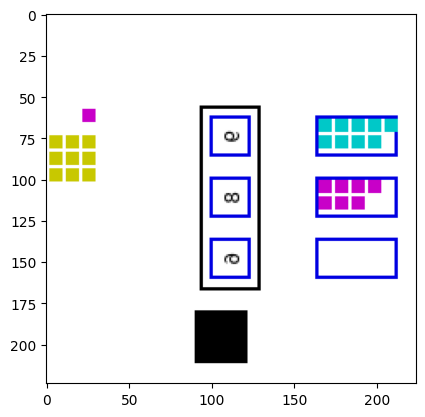

4
ACTION[4] REWARD[0.1]
Next , pick up the first unit block .
 [101, 2279, 1010, 4060, 2039, 1996, 2034, 3131, 3796, 1012, 102]
['[CLS]', 'next', ',', 'pick', 'up', 'the', 'first', 'unit', 'block', '.', '[SEP]']
11


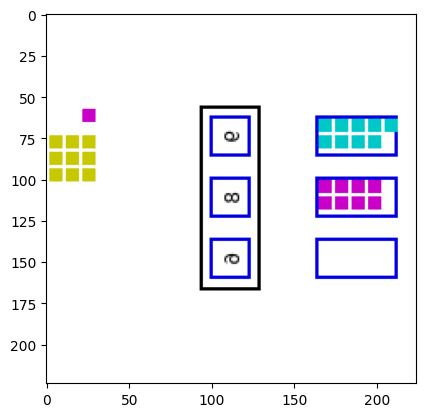

2
ACTION[2] REWARD[0.1]
Put the unit block in the unit's place .
 [101, 2404, 1996, 3131, 3796, 1999, 1996, 3131, 1005, 1055, 2173, 1012, 102]
['[CLS]', 'put', 'the', 'unit', 'block', 'in', 'the', 'unit', "'", 's', 'place', '.', '[SEP]']
13


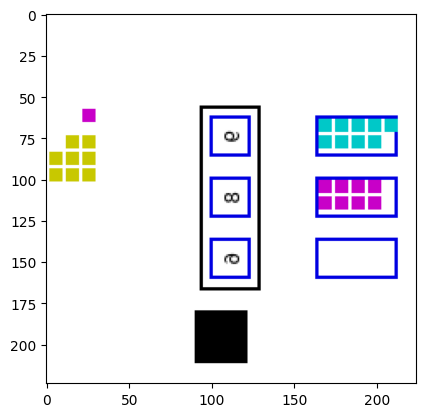

5
ACTION[5] REWARD[0.1]
Next , pick up the second unit block .
 [101, 2279, 1010, 4060, 2039, 1996, 2117, 3131, 3796, 1012, 102]
['[CLS]', 'next', ',', 'pick', 'up', 'the', 'second', 'unit', 'block', '.', '[SEP]']
11


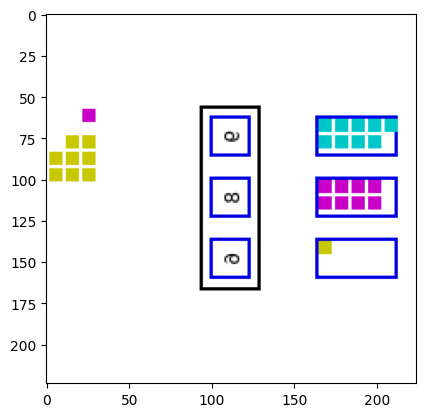

2
ACTION[2] REWARD[0.1]
Put the unit block in the unit's place .
 [101, 2404, 1996, 3131, 3796, 1999, 1996, 3131, 1005, 1055, 2173, 1012, 102]
['[CLS]', 'put', 'the', 'unit', 'block', 'in', 'the', 'unit', "'", 's', 'place', '.', '[SEP]']
13


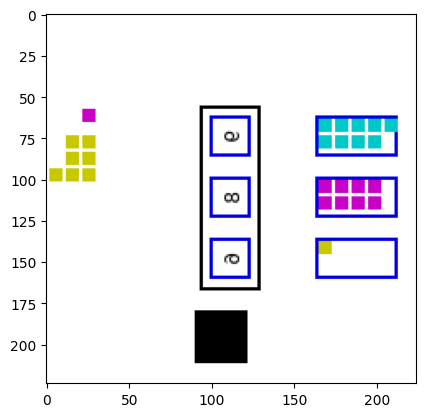

5
ACTION[5] REWARD[0.1]
Next , pick up the third unit block .
 [101, 2279, 1010, 4060, 2039, 1996, 2353, 3131, 3796, 1012, 102]
['[CLS]', 'next', ',', 'pick', 'up', 'the', 'third', 'unit', 'block', '.', '[SEP]']
11


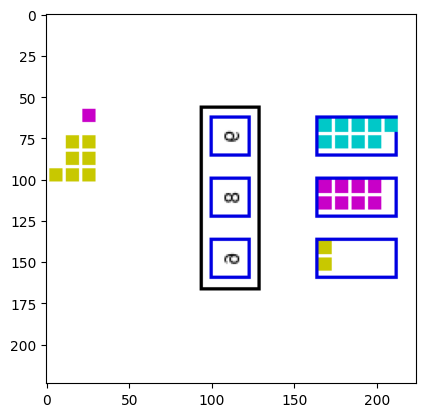

2
ACTION[2] REWARD[0.1]
Put the unit block in the unit's place .
 [101, 2404, 1996, 3131, 3796, 1999, 1996, 3131, 1005, 1055, 2173, 1012, 102]
['[CLS]', 'put', 'the', 'unit', 'block', 'in', 'the', 'unit', "'", 's', 'place', '.', '[SEP]']
13


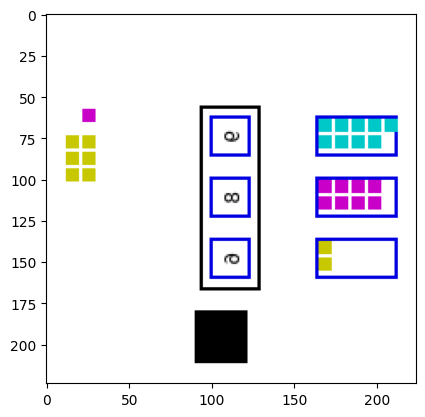

5
ACTION[5] REWARD[0.1]
Next , pick up the fourth unit block .
 [101, 2279, 1010, 4060, 2039, 1996, 2959, 3131, 3796, 1012, 102]
['[CLS]', 'next', ',', 'pick', 'up', 'the', 'fourth', 'unit', 'block', '.', '[SEP]']
11


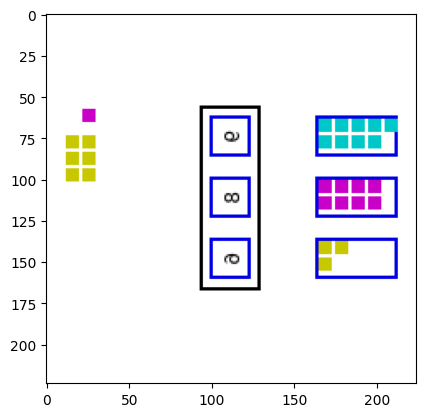

2
ACTION[2] REWARD[0.1]
Put the unit block in the unit's place .
 [101, 2404, 1996, 3131, 3796, 1999, 1996, 3131, 1005, 1055, 2173, 1012, 102]
['[CLS]', 'put', 'the', 'unit', 'block', 'in', 'the', 'unit', "'", 's', 'place', '.', '[SEP]']
13


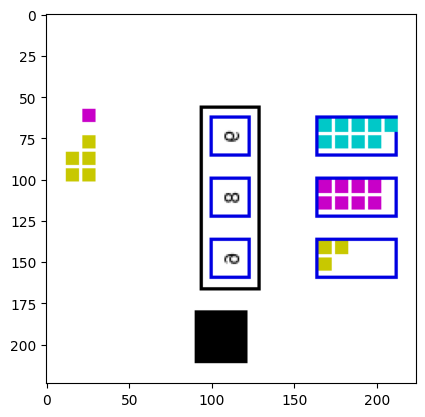

5
ACTION[5] REWARD[0.1]
Next , pick up the fifth unit block .
 [101, 2279, 1010, 4060, 2039, 1996, 3587, 3131, 3796, 1012, 102]
['[CLS]', 'next', ',', 'pick', 'up', 'the', 'fifth', 'unit', 'block', '.', '[SEP]']
11


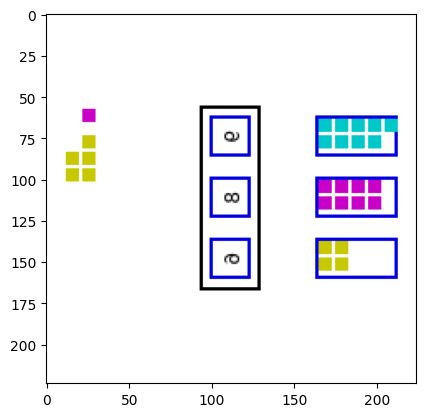

2
ACTION[2] REWARD[0.1]
Put the unit block in the unit's place .
 [101, 2404, 1996, 3131, 3796, 1999, 1996, 3131, 1005, 1055, 2173, 1012, 102]
['[CLS]', 'put', 'the', 'unit', 'block', 'in', 'the', 'unit', "'", 's', 'place', '.', '[SEP]']
13


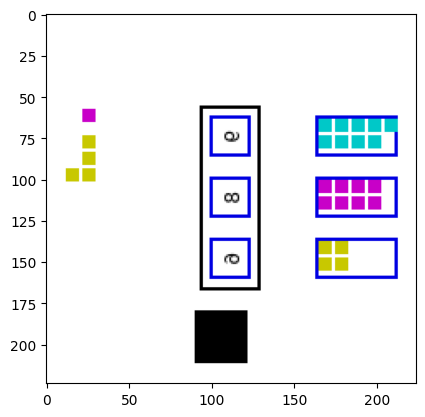

5
ACTION[5] REWARD[0.1]
Next , pick up the sixth unit block .
 [101, 2279, 1010, 4060, 2039, 1996, 4369, 3131, 3796, 1012, 102]
['[CLS]', 'next', ',', 'pick', 'up', 'the', 'sixth', 'unit', 'block', '.', '[SEP]']
11


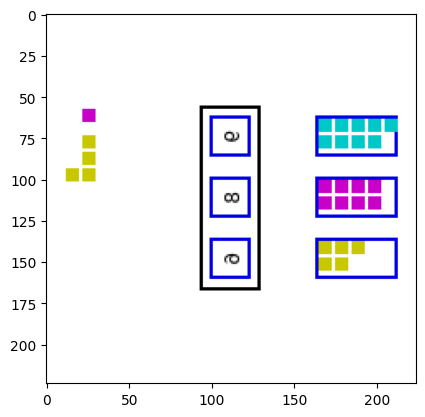

2
ACTION[2] REWARD[0.1]
Put the unit block in the unit's place .
 [101, 2404, 1996, 3131, 3796, 1999, 1996, 3131, 1005, 1055, 2173, 1012, 102]
['[CLS]', 'put', 'the', 'unit', 'block', 'in', 'the', 'unit', "'", 's', 'place', '.', '[SEP]']
13


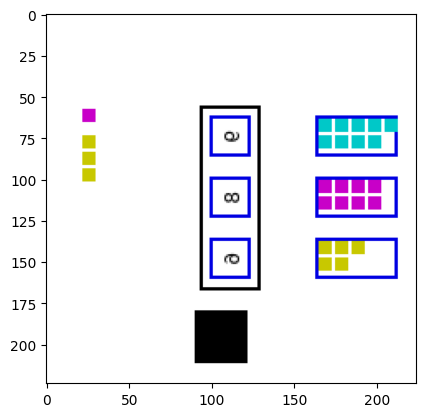

5
Cumulative Reward ~ 5.5; TimeTaken ~ 46


In [7]:
best_env(number = 986)

In [ ]:
!python3 -W ignore ppo.py

In [ ]:
plot_ppo(suffix[0][-1])
run_best_env(1,suffix[0][-1])

In [ ]:
!python3 -W ignore ppo.py --model 1 --ease -1 --log 20

In [ ]:
plot_ppo(suffix[1][-1])
run_best_env(1,suffix[1][-1])

## Run more difficult tasks.

In [ ]:
!python3 -W ignore ppo.py --model 0 --ease 0

In [ ]:
plot_ppo(suffix[0][0]) # Plot training set.

arr = []
with open(f'results/test_set{suffix[0][0]}.json', 'r') as file:
    arr=json.load(file)

run_best_env(arr[-1],suffix[0][0]) # See the performance on the most difficult number.

In [ ]:
!python3 -W ignore ppo.py --model 1 --ease 0

In [ ]:
plot_ppo(suffix[1][0]) # Plot training set.

arr = []
with open(f'results/test_set{suffix[0][0]}.json', 'r') as file:
    arr=json.load(file)

run_best_env(arr[-1],suffix[1][0]) # See the performance on the most difficult number.